# Montgomery County Collision Analysis

## Introduction
<br>We will be examining traffic collisions that occurred in Montgomery County, Maryland. Our data set has over fifteen thousand collision reports based on preliminary data. The data set includes columns such as the time of day that the crash occurred, the vehicle's impact locations, and the vehicle's movement at the time of the collision. We will be using this data to see what aspects of a crash lead to lower or higher rates of injury severity. Therefore, we are most interested in the correlation of 'Injury Severity', 'Vehicle Body Type', and 'Vehicle Movement' and others. We will create new columns based on factors that are most apparent to our exploration of the data.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
df_county = pd.read_csv('data/Crash_Reporting_-_Drivers_Data.csv')
df_state = pd.read_csv('data/Maryland_Statewide_Vehicle_Crashes.csv')
df_nonmotor = pd.read_csv('data/Crash_Reporting_-_Non-Motorists_Data.csv')

In [3]:
df_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157554 entries, 0 to 157553
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   157554 non-null  object 
 1   Local Case Number               157554 non-null  object 
 2   Agency Name                     157554 non-null  object 
 3   ACRS Report Type                157554 non-null  object 
 4   Crash Date/Time                 157554 non-null  object 
 5   Route Type                      142110 non-null  object 
 6   Road Name                       142960 non-null  object 
 7   Cross-Street Type               142086 non-null  object 
 8   Cross-Street Name               142954 non-null  object 
 9   Off-Road Description            14592 non-null   object 
 10  Municipality                    17502 non-null   object 
 11  Related Non-Motorist            4958 non-null    object 
 12  Collision Type  

In [4]:
df_county['Crash Date/Time'] = pd.to_datetime(df_county['Crash Date/Time'])
df_county['YEAR'] = df_county['Crash Date/Time'].dt.year
df_county['MONTH'] = df_county['Crash Date/Time'].dt.month
df_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157554 entries, 0 to 157553
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Report Number                   157554 non-null  object        
 1   Local Case Number               157554 non-null  object        
 2   Agency Name                     157554 non-null  object        
 3   ACRS Report Type                157554 non-null  object        
 4   Crash Date/Time                 157554 non-null  datetime64[ns]
 5   Route Type                      142110 non-null  object        
 6   Road Name                       142960 non-null  object        
 7   Cross-Street Type               142086 non-null  object        
 8   Cross-Street Name               142954 non-null  object        
 9   Off-Road Description            14592 non-null   object        
 10  Municipality                    17502 non-null   object 

In [5]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   878343 non-null  int64  
 1   QUARTER                878343 non-null  object 
 2   LIGHT_DESC             841025 non-null  object 
 3   LIGHT_CODE             878343 non-null  float64
 4   COUNTY_DESC            878329 non-null  object 
 5   COUNTY_NO              878329 non-null  float64
 6   MUNI_DESC              0 non-null       float64
 7   MUNI_CODE              659957 non-null  float64
 8   JUNCTION_DESC          760119 non-null  object 
 9   JUNCTION_CODE          791512 non-null  float64
 10  COLLISION_TYPE_DESC    878343 non-null  object 
 11  COLLISION_TYPE_CODE    878343 non-null  int64  
 12  SURF_COND_DESC         789107 non-null  object 
 13  SURF_COND_CODE         791512 non-null  float64
 14  LANE_CODE              668083 non-nu

In [6]:
# Merge the two dataframes with the values that do not already exist in the county data
df_county = pd.merge(left=df_county, right=df_nonmotor[~df_nonmotor['Report Number'].isin(df_county['Report Number'])], on='Report Number', how='left')
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157554 entries, 0 to 157553
Data columns (total 76 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Report Number                     157554 non-null  object        
 1   Local Case Number_x               157554 non-null  object        
 2   Agency Name_x                     157554 non-null  object        
 3   ACRS Report Type_x                157554 non-null  object        
 4   Crash Date/Time_x                 157554 non-null  datetime64[ns]
 5   Route Type_x                      142110 non-null  object        
 6   Road Name_x                       142960 non-null  object        
 7   Cross-Street Type_x               142086 non-null  object        
 8   Cross-Street Name_x               142954 non-null  object        
 9   Off-Road Description_x            14592 non-null   object        
 10  Municipality_x                  

## Data Cleaning
<br>
Let us now drop columns that are missing more than 10% of values on average

In [7]:
df_county.drop(columns=df_county.columns[df_county.isna().mean() >= .1], inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157554 entries, 0 to 157553
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Report Number                   157554 non-null  object        
 1   Local Case Number_x             157554 non-null  object        
 2   Agency Name_x                   157554 non-null  object        
 3   ACRS Report Type_x              157554 non-null  object        
 4   Crash Date/Time_x               157554 non-null  datetime64[ns]
 5   Route Type_x                    142110 non-null  object        
 6   Road Name_x                     142960 non-null  object        
 7   Cross-Street Type_x             142086 non-null  object        
 8   Cross-Street Name_x             142954 non-null  object        
 9   Collision Type_x                157028 non-null  object        
 10  Weather_x                       145184 non-null  object 

Let us overwrite the state DataFrame with only the columns that we would like to analyze.

In [9]:
df_state = df_state[[  'YEAR', 'LIGHT_DESC', 'COUNTY_DESC',
                       'COLLISION_TYPE_DESC',
                       'REPORT_NO', 'WEATHER_CODE', 'ACC_DATE',
                       'LATITUDE', 'LONGITUDE', 'LOCATION']]
df_state.isna().sum()

YEAR                       0
LIGHT_DESC             37318
COUNTY_DESC               14
COLLISION_TYPE_DESC        0
REPORT_NO                  0
WEATHER_CODE               0
ACC_DATE                   0
LATITUDE                   0
LONGITUDE                  0
LOCATION                   0
dtype: int64

In [10]:
df_state['LIGHT_DESC'] = df_state['LIGHT_DESC'].fillna(df_state['LIGHT_DESC'].value_counts().index[0])
df_state['COUNTY_DESC'] = df_state['COUNTY_DESC'].fillna('NA')

In [11]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 878343 non-null  int64  
 1   LIGHT_DESC           878343 non-null  object 
 2   COUNTY_DESC          878343 non-null  object 
 3   COLLISION_TYPE_DESC  878343 non-null  object 
 4   REPORT_NO            878343 non-null  object 
 5   WEATHER_CODE         878343 non-null  float64
 6   ACC_DATE             878343 non-null  int64  
 7   LATITUDE             878343 non-null  float64
 8   LONGITUDE            878343 non-null  float64
 9   LOCATION             878343 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 67.0+ MB


Let us clean the Vehicle Body Type column so that the categories are more apparent.

In [59]:
df_county['Simple Vehicle Body Type'] = df_county['Vehicle Body Type'].replace({'TRANSIT BUS':"BUS", "SCHOOL BUS": "BUS", "(SPORT) UTILITY VEHICLE": "SUV", "OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)": "LIGHT SEMITRUCKS", "CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))": "MEDIUM SEMITRUCKS", "POLICE VEHICLE/NON EMERGENCY": "POLICE", "POLICE VEHICLE/EMERGENCY":"POLICE", "MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))":"HEAVY SEMITRUCK", "STATION WAGON":"SUV", "TRUCK TRACTOR":"TRACTOR", "AMBULANCE/EMERGENCY":"FIRST RESPONDER", "FIRE VEHICLE/EMERGENCY":"FIRST RESPONDER","OTHER BUS":"BUS","FIRE VEHICLE/NON EMERGENCY":"FIRST RESPONDER", "RECREATIONAL VEHICLE":"RV", "AMBULANCE/NON EMERGENCY":'FIRST RESPONDER', 'ALL TERRAIN VEHICLE (ATV)':"ATV"})
# df_county['Simple Vehicle Body Type'] = df_county['Simple Vehicle Body Type'].drop(axis='columns', ['MOPED', 'AUTOCYCLE', 'LOW SPEED VEHICLE', 'CROSS COUNTRY BUS', 'FARM VEHICLE', 'LIMOUSINE'])
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'MOPED']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'AUTOCYCLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LOW SPEED VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'CROSS COUNTRY BUS']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'FARM VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LIMOUSINE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'UNKNOWN']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'OTHER']

In [14]:
df_county['Numeric Severity'] = df_county['Injury Severity_x'].replace({'NO APPARENT INJURY': 0, 'POSSIBLE INJURY': 1, 'SUSPECTED MINOR INJURY': 2, 'SUSPECTED SERIOUS INJURY':3, 'FATAL INJURY':4})

## Data Visualization

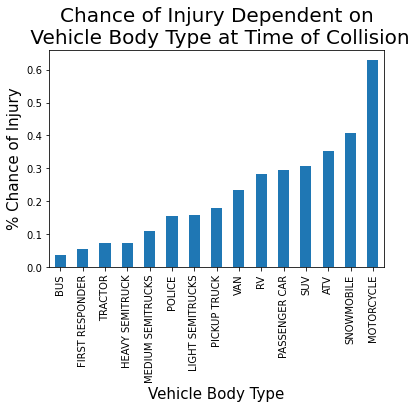

In [15]:
first_x_vals = df_county.groupby('Simple Vehicle Body Type')['Numeric Severity'].mean().sort_values()[:-1]
last_x_vals =  pd.Series(df_county.groupby('Simple Vehicle Body Type')['Numeric Severity'].mean().sort_values()[-1]-1).rename({0:"MOTORCYCLE"})
last_x_vals.name = "Numeric Severity"
first_x_vals.append(last_x_vals).plot.bar()
plt.title('Chance of Injury Dependent on\n Vehicle Body Type at Time of Collision', size=20)
plt.ylabel('% Chance of Injury', size = 15)
plt.xlabel("Vehicle Body Type", size = 15);

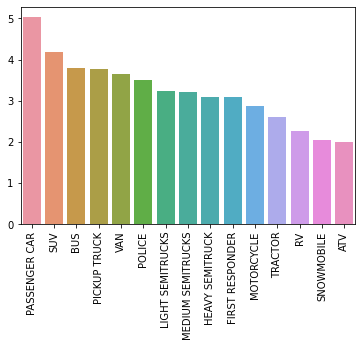

In [58]:
x = df_county['Simple Vehicle Body Type'].value_counts().index
y = np.log10(df_county['Simple Vehicle Body Type'].value_counts().values)
sns.barplot(x,y)
plt.xticks(rotation=90);
# plt.ylabel()
# plt.xlabel()
# plt.ylabel()

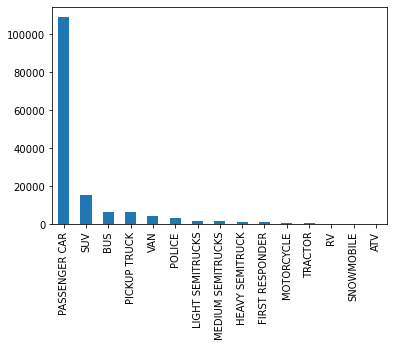

In [17]:
df_county['Simple Vehicle Body Type'].value_counts().plot.bar();


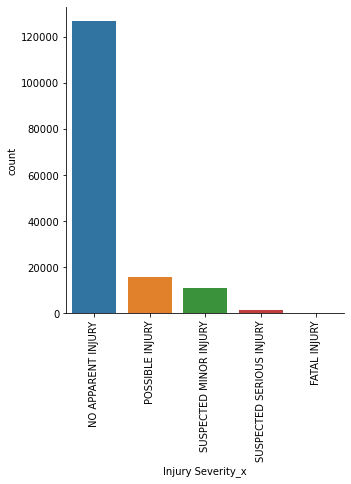

In [18]:
sns.catplot(x='Injury Severity_x', kind='count', data=df_county)
plt.xticks(rotation=90);

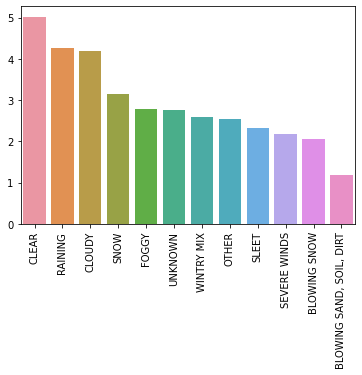

In [19]:
x = df_county['Weather_x'].value_counts().index
y = np.log10(df_county['Weather_x'].value_counts().values)
sns.barplot(x,y)
plt.xticks(rotation=90);

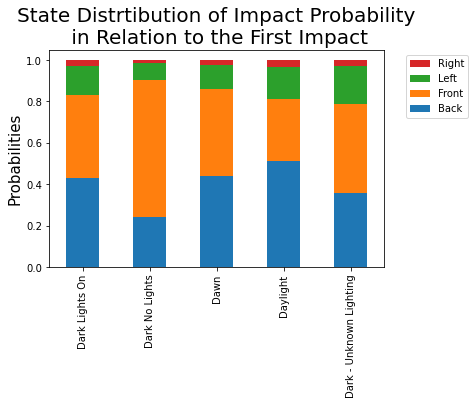

In [57]:
df_state['First Impact Simple'] = df_state['COLLISION_TYPE_DESC'].replace({"Same Direction Rear End":"Back", "Single Vehicle":"Front", "Same Movement Angle":"Back", "Same Direction Sideswipe":"Left", "Head On Left Turn":"Front", "Head On":"Front", "Same Direction Right Turn":"Right", "Same Direction Left Turn":"Left", "Opposite Direction Sideswipe":"Left", "Same Direction Rear End Left Turn":"Back", "Angle Meets Left Turn":"Left", "Same Direction Rear End Right Turn":"Back", "Same Direction Both Left Turn":"Left", "Angle Meets Right Turn":"Right", "Angle Meets Left Turn Head On":"Front", "Opposite Direction Both Left Turn":"Left"})
df_state = df_state[df_state['First Impact Simple'] != "Unknown"]
df_state = df_state[df_state['First Impact Simple'] != "Not Applicable"]
df_state = df_state[df_state['First Impact Simple'] != "Other"]

movementImpact = pd.crosstab(df_state['LIGHT_DESC'], df_state['First Impact Simple'])
movementImpact = movementImpact.div(df_state['LIGHT_DESC'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('State Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

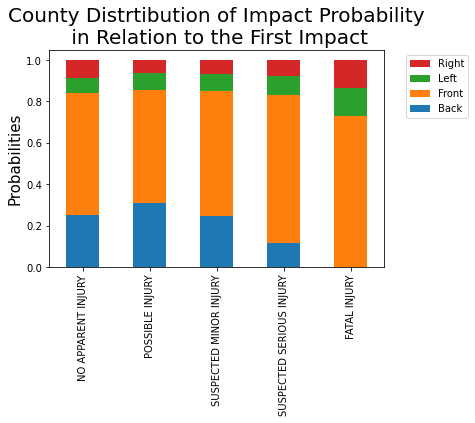

In [56]:
# Replace to simple impact locations
df_county['First Impact Simple'] = df_county['Vehicle First Impact Location'].replace({'ELEVEN OCLOCK': "Front", 'TWELVE OCLOCK': "Front", 'ONE OCLOCK': "Front", 'TWO OCLOCK': "Right", 'THREE OCLOCK': "Right", 'FOUR OCLOCK': "Right", 'FIVE OCLOCK': "Back", 'SIX OCLOCK': "Back", 'SEVEN OCLOCK': "Back", 'EIGHT OCLOCK': "Left", 'NINE OCLOCK': "Left", 'TEN OCLOCK': "Left", 'ROOF TOP': "Top", 'UNDERSIDE': "Bottom", 'NON-COLLISION': "No Collision",'UNKNOWK': "Unknown"})
# We will drop these values because they are unusual to compare with collisions 
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'UNKNOWN'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Top'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Bottom'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'No Collision'], inplace = True)
# Create cross tab chart 
movementImpact = pd.crosstab(df_county['Injury Severity_x'], df_county['First Impact Simple'])
movementImpact = movementImpact.div(df_county['Injury Severity_x'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('County Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [21]:
df_county['Weather_x'] = df_county['Weather_x'].replace(
    {"BLOWING SAND, SOIL, DIRT": "OTHER",
     "WINTRY MIX": "OTHER" , "BLOWING SNOW": "OTHER", "UNKNOWN": "OTHER"})
df_county = df_county[df_county['Weather_x']!="OTHER"]
df_county['Weather_x'].value_counts()
# df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].dropna(how='any')
# df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].replace(
#     {"Blowing Sand, Soil, Dirt": "Other",
#      "Wintry Mix": "Other" , "Blowing Snow": "Other", "Unknown": "Other"})
# df_state['WEATHER_DESC'].value_counts()

CLEAR           102288
RAINING          18368
CLOUDY           15452
SNOW              1349
FOGGY              606
SLEET              204
SEVERE WINDS       142
Name: Weather_x, dtype: int64

In [35]:
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150144 entries, 0 to 157553
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Report Number                   150144 non-null  object        
 1   Local Case Number_x             150144 non-null  object        
 2   Agency Name_x                   150144 non-null  object        
 3   ACRS Report Type_x              150144 non-null  object        
 4   Crash Date/Time_x               150144 non-null  datetime64[ns]
 5   Route Type_x                    136353 non-null  object        
 6   Road Name_x                     137154 non-null  object        
 7   Cross-Street Type_x             136330 non-null  object        
 8   Cross-Street Name_x             137148 non-null  object        
 9   Collision Type_x                149701 non-null  object        
 10  Weather_x                       138409 non-null  object 

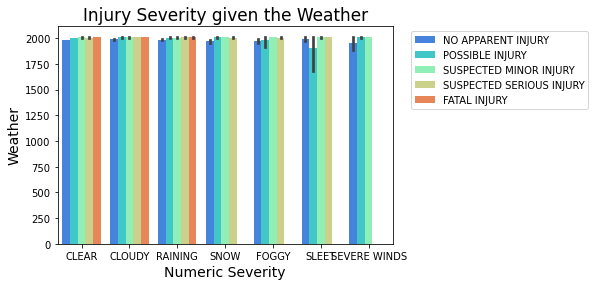

In [55]:
## TODO


# What effect does weather have on injury severity
# df_county['Weather_x'].value_counts().plot.bar()
sns.barplot(x="Weather_x", y="Vehicle Year", data=df_county, palette="rainbow", hue="Injury Severity_x")
# sns.catplot(x="Numeric Severity", y="Weather_x", hue="Injury Severity_x", kind='bar', data=df_county, aspect=12/8.2)
# df_county['Weather_x'].value_counts()
plt.legend(bbox_to_anchor=(1.6, 1.0),loc="upper right")
plt.ylabel("Weather", size=14)
plt.xlabel("Numeric Severity", size=14)
plt.title("Injury Severity given the Weather", size=17);

## Conclusion